<a href="https://colab.research.google.com/github/sriharshitha12/python-project_1261/blob/main/netflix%20dataset%20code%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


✅ Model Accuracy: 99.60%
✅ Model Precision: 99.60%


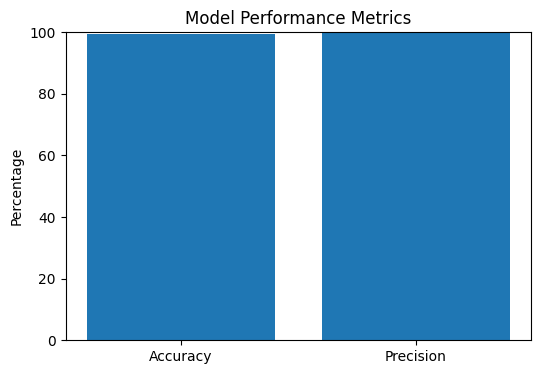

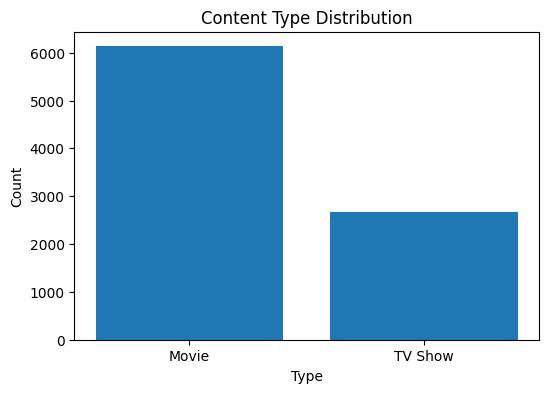

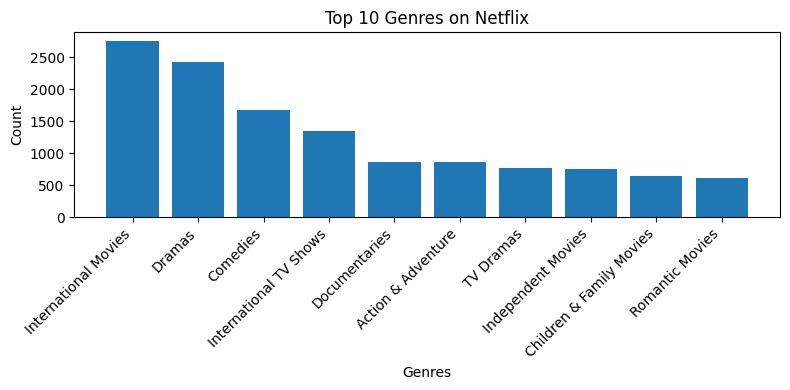

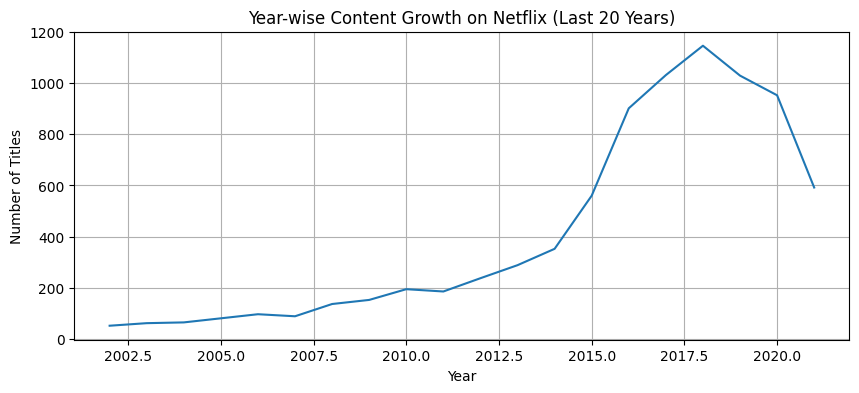

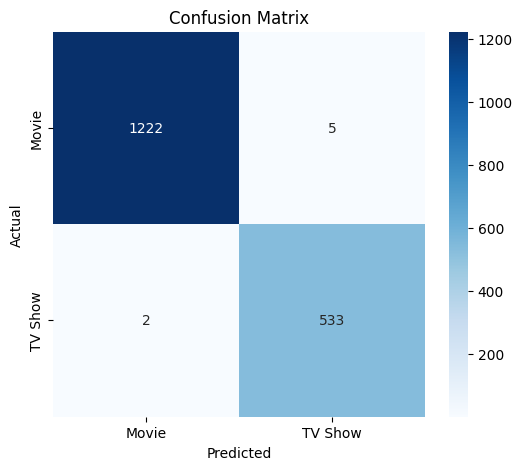


🎬 Recommended titles similar to 'Breaking Bad':
                                          title  \
2606                            Extracurricular   
4118                                Iron Ladies   
4143                                     Sparta   
5352  Have You Ever Fallen in Love, Miss Jiang?   
2931                           Better Call Saul   

                                              listed_in  \
2606  Crime TV Shows, International TV Shows, Korean...   
4118  International TV Shows, Romantic TV Shows, TV ...   
4143  Crime TV Shows, International TV Shows, TV Dramas   
5352  Crime TV Shows, International TV Shows, TV Dramas   
2931             Crime TV Shows, TV Comedies, TV Dramas   

                                            description  
2606  A model high school student who's steeped in a...  
4118  Three 30-something women in high-level jobs at...  
4143  While investigating the mysterious death of a ...  
5352  A new teacher finds herself in an unenviable s...  

In [2]:
# === Netflix Content-Based Recommender with Visual Analytics ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns

# === Step 1: Load Dataset ===
try:
    df = pd.read_csv("netflix_titles.csv.csv")
except:
    df = pd.read_csv("netflix_titles.csv")

# === Step 2: Data Cleaning ===
df.dropna(subset=['title', 'description', 'listed_in'], inplace=True)
df.fillna('', inplace=True)

# Combine metadata
df['content'] = df['title'] + " " + df['listed_in'] + " " + df['description']

# === Step 3: Encode Target ===
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# === Step 4: TF-IDF Vectorization ===
tfidf = TfidfVectorizer(stop_words='english', max_features=8000)
X = tfidf.fit_transform(df['content'])
y = df['type_encoded']

# === Step 5: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Step 6: Ensemble Classifier ===
rf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=42)
lr = LogisticRegression(max_iter=400)
nb = MultinomialNB()

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('lr', lr), ('nb', nb)],
    voting='soft'
)

# Train model
ensemble.fit(X_train, y_train)

# === Step 7: Evaluate ===
y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')

print(f"\n✅ Model Accuracy: {acc*100:.2f}%")
print(f"✅ Model Precision: {prec*100:.2f}%")

# === Step 8: Visualizations ===

# 1. Model Performance Bar Chart
plt.figure(figsize=(6,4))
plt.bar(['Accuracy', 'Precision'], [acc*100, prec*100])
plt.title('Model Performance Metrics')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()

# 2. Content Type Distribution
type_counts = df['type'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(type_counts.index, type_counts.values)
plt.title('Content Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# 3. Genre Frequency Plot
all_genres = df['listed_in'].str.split(', ')
genres_exploded = all_genres.explode()
genre_counts = genres_exploded.value_counts().head(10)

plt.figure(figsize=(8,4))
plt.bar(genre_counts.index, genre_counts.values)
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Release Year Trend
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
year_counts = df['release_year'].value_counts().sort_index().tail(20)

plt.figure(figsize=(10,4))
plt.plot(year_counts.index, year_counts.values)
plt.title('Year-wise Content Growth on Netflix (Last 20 Years)')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.grid(True)
plt.show()

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Movie', 'TV Show'], yticklabels=['Movie', 'TV Show'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === Step 9: Recommendation Function ===
cosine_sim = cosine_similarity(X, X)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def recommend(title, num=5):
    if title not in indices:
        return f"❌ '{title}' not found in dataset."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num+1]
    rec_indices = [i[0] for i in sim_scores]
    return df[['title', 'listed_in', 'description']].iloc[rec_indices]

# === Example Recommendation ===
print("\n🎬 Recommended titles similar to 'Breaking Bad':")
print(recommend("Breaking Bad"))
